In [13]:
STREAM = 'Elqui'

In [14]:
# Fit results (by eye)
pmRA, pmDEC = -0.3, 0.3
pmPHI1, pmPHI2 = 0.5, 0.1

In [15]:
ra_NGC300, dec_NGC300 = 13.7229167, -37.6844444
ra_sculptor, dec_sculptor = 15.0391667, -33.7088889

pmra_sculptor, pmdec_sculptor = -0.23, 0.45
pmra0_sculptor, pmdec0_sculptor = 0.09, 0.02

pmphi1_sculptor, pmphi2_sculptor = 0.8, 0.3 # by eye

In [16]:
MAG = 'WAVG_MAG_PSF_%s_DERED'
MAGG = MAG%'G'
MAGR = MAG%'R'
MAGI = MAG%'I'
MAGZ = MAG%'Z'

https://cdcvs.fnal.gov/redmine/projects/des-mw/wiki/Projected_Stream_Figures

In [17]:
%matplotlib inline

In [18]:
from __future__ import division

In [19]:
import sys
sys.path.append('/Users/nora/projects/proper_motions/code')

In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [22]:
import proper_motions as pm
reload(pm)
import results
import streamlib
import load_stream

In [23]:
pm.plot_pretty(fontsize=15)

In [120]:
def select_on(data, stream, width=1.0):
    idx_on = (np.abs(data['PHI2']) < width / 2.)
    idx_on &= (np.abs(data['PHI1'] < stream['length_deg'] / 2.))
    return data[idx_on], idx_on

def select_off(data, stream, width=1.0, offset=1.0):
    off_min = offset - width / 2.
    off_max = offset + width / 2.
    idx_off = (np.abs(data['PHI2']) < off_max) & (np.abs(data['PHI2']) > off_min)
    return data[idx_off], idx_off


## Load stream

In [24]:
res = pm.load_stream.create_results(pm.load_stream.streamlib.load_streams())
stream = res[STREAM]

In [25]:
on_width, off_width, offset = stream['selection_parameters']

In [26]:
gaia_des, des = pm.load_data(STREAM)

## Load isochrone

In [27]:
mu = stream['modulus']

age2, z2 = 12.5, 0.0001
age, z = stream['age'], stream['metallicity']
# print age, z, age2, z2

iso = pm.isochrone_factory('Dotter2008', age=age, z=z)
iso2 = pm.isochrone_factory('Dotter2008', age=age2, z=z2)

# DES

## Select on- and off- stream regions

In [121]:
data = np.copy(des)
# _, on_stream = pm.select_on(data, stream, on_width)
# _, off_stream = pm.select_off(data, stream, off_width, offset)

_, on_stream = select_on(data, stream, on_width)
_, off_stream = select_off(data, stream, off_width, offset)

# on_stream &= data['PHI1'] < 0
# off_stream &= data['PHI2'] < 0

## Plot Hess

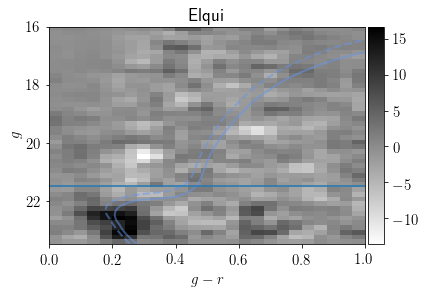

In [29]:
im = pm.plot_hess(stream, data[on_stream], data[off_stream])
plt.axhline(21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.5, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.5, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.xlim(0,1)
plt.ylim(23.5,16)
pm.colorbar(im)

# Gaia x DES

## Select on- and off- stream

In [123]:
data = np.copy(gaia_des)
# _, on_stream = pm.select_on(data, stream, on_width)
# _, off_stream = pm.select_off(data, stream, off_width, offset)

_, on_stream = select_on(data, stream, on_width)
_, off_stream = select_off(data, stream, off_width, offset)

on_stream &= data['PHI1'] < 0
off_stream &= data['PHI2'] < 0

## Plot Gaia-matched DES Hess

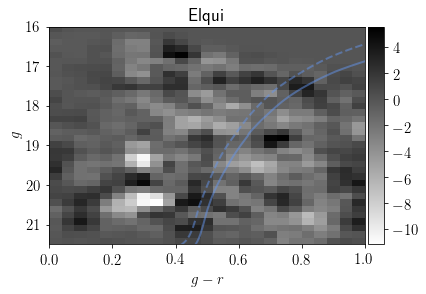

In [124]:
# im = plot_hess(stream, data[on_stream], data[off_stream], gmax=21.5, vmin=-5, vmax=35)
im = pm.plot_hess(stream, data[on_stream], data[off_stream], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.5, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.5, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

## Plot r-i vs. g-r

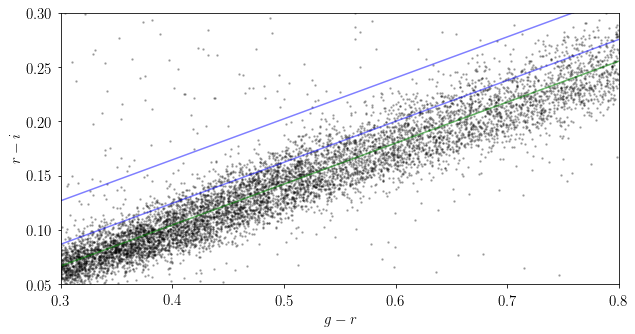

In [125]:
p = pm.calculate_locus(data)

# plot_color(stream, data[on_stream], data[off_stream])
plt.figure(figsize=(10,5))
plt.plot(data[MAGG][on_stream] - data[MAGR][on_stream], data[MAGR][on_stream] - data[MAGI][on_stream], 'k.', ms=3, alpha=0.25)
# plt.plot(data[MAGG][on_stream&pm_cut] - data[MAGR][on_stream&pm_cut], data[MAGR][on_stream&pm_cut] - data[MAGI][on_stream&pm_cut], 'g.', ms=3, alpha=0.5)
plt.xlim(0.3,0.8)
plt.ylim(0.05,0.3)
plt.xlabel(r'$g-r$')
plt.ylabel(r'$r-i$')

xx = np.linspace(0.3,0.8,100)
plt.plot(xx, p[0]*xx + p[1], 'g--', alpha=0.25)
plt.plot(xx, pm.locus(xx, p), 'g-', alpha=0.5)
plt.plot(xx, pm.locus(xx, p)+0.02, 'b-', alpha=0.5)
plt.plot(xx, pm.locus(xx, p)+0.06, 'b-', alpha=0.5)
plt.show()

## Color-magnitude and color-color selections

In [126]:
_, ri_cut = pm.select_gr_ri(data, stream, dmin=0.02, dmax=0.06, p=p)
_, iso_cut1 = pm.select_isochrone(data, stream, iso_params=[mu, age, z])
_, iso_cut2 = pm.select_isochrone(data, stream, C=[0.01,0.01], E=2, iso_params=[mu, age, z])
_, iso_cut3 = pm.select_isochrone(data, stream, C=[0.005,0.005], E=4, iso_params=[mu, age, z])

iso_cut = np.copy(iso_cut1)

mag_cut = data[MAGG] < 19.
color_cut = data[MAGG] - data[MAGR] > 0.4
plx_cut = data['PARALLAX'] < 0.5

iso_cut &= mag_cut
ri_cut &= color_cut

Text(0,0.5,'$r-i$')

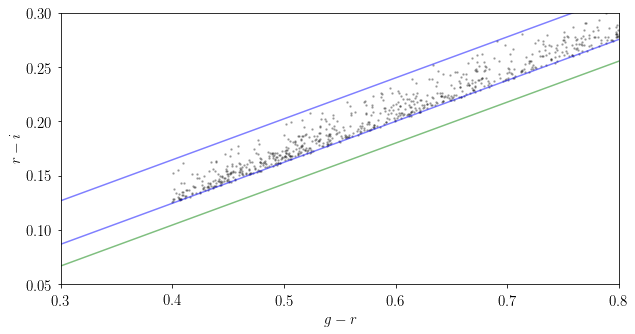

In [127]:
plt.figure(figsize=(10,5))
plt.plot(data[MAGG][on_stream&ri_cut] - data[MAGR][on_stream&ri_cut], data[MAGR][on_stream&ri_cut] - data[MAGI][on_stream&ri_cut], 'k.', ms=3, alpha=0.25)
plt.plot(xx, pm.locus(xx, p), 'g-', alpha=0.5)
plt.plot(xx, pm.locus(xx, p)+0.02, 'b-', alpha=0.5)
plt.plot(xx, pm.locus(xx, p)+0.06, 'b-', alpha=0.5)
plt.xlim(0.3,0.8)
plt.ylim(0.05,0.3)
plt.xlabel(r'$g-r$')
plt.ylabel(r'$r-i$')


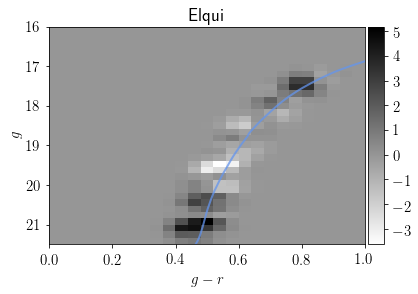

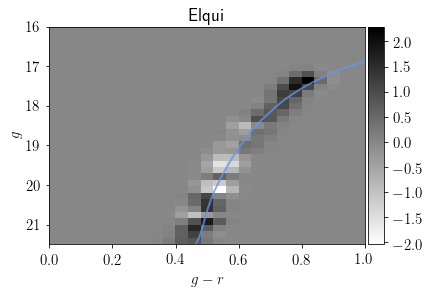

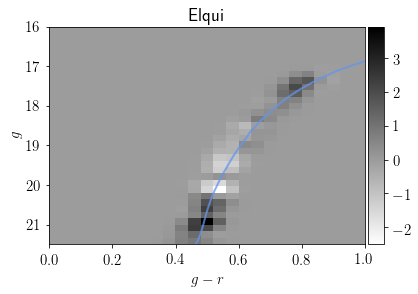

In [128]:
# Three isochrone selections: loosest --> tightest

im = pm.plot_hess(stream, data[on_stream&iso_cut1], data[off_stream&iso_cut1], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

im = pm.plot_hess(stream, data[on_stream&iso_cut2], data[off_stream&iso_cut2], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

im = pm.plot_hess(stream, data[on_stream&iso_cut3], data[off_stream&iso_cut3], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

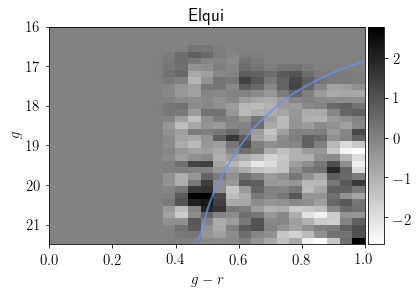

In [129]:
# w/ color-color cut

im = pm.plot_hess(stream, data[on_stream&ri_cut], data[off_stream&ri_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

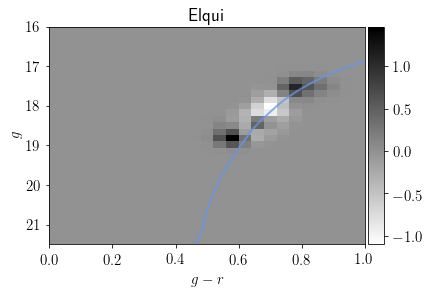

In [130]:
# w/ isochrone cut and color-color cut

im = pm.plot_hess(stream, data[on_stream&iso_cut&ri_cut], data[off_stream&iso_cut&ri_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

# Proper Motions

### Spatial cuts only

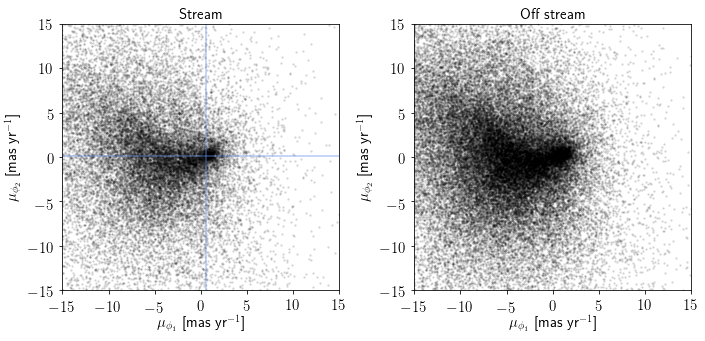

In [131]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(data['PMPHI1'][on_stream], data['PMPHI2'][on_stream], 'k.', ms=3, alpha=0.1)

plt.axvline(pmPHI1, alpha=0.5, c='cornflowerblue')
plt.axhline(pmPHI2, alpha=0.5, c='cornflowerblue')

# plt.axvline(pmPHI1_sculptor, alpha=0.5, c='r', ls='--')
# plt.axhline(pmPHI2_sculptor, alpha=0.5, c='r', ls='--')

plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(data['PMPHI1'][off_stream], data['PMPHI2'][off_stream], 'k.', ms=3, alpha=0.1)

plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()

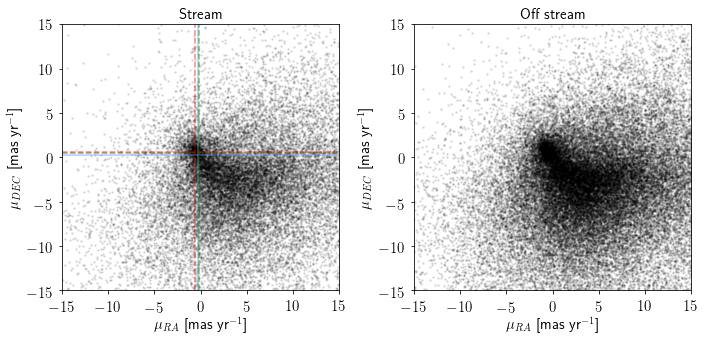

In [132]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(data['PMRA'][on_stream], data['PMDEC'][on_stream], 'k.', ms=3, alpha=0.1)

plt.axvline(pmRA, alpha=0.5, c='cornflowerblue')
plt.axhline(pmDEC, alpha=0.5, c='cornflowerblue')

plt.axvline(pmra_sculptor, alpha=0.5, c='g', ls='--')
plt.axhline(pmdec_sculptor, alpha=0.5, c='g', ls='--')


pmra_clump = -0.6
pmdec_clump = 0.6
plt.axvline(pmra_clump, alpha=0.5, c='r', ls='--')
plt.axhline(pmdec_clump, alpha=0.5, c='r', ls='--')


plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('$\mu_{RA}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{DEC}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(data['PMRA'][off_stream], data['PMDEC'][off_stream], 'k.', ms=3, alpha=0.1)

plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('$\mu_{RA}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{DEC}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()

### Spatial + isochrone cuts

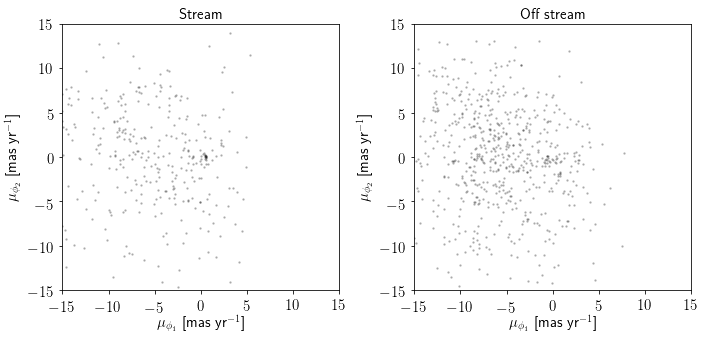

In [133]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(data['PMPHI1'][on_stream&iso_cut], data['PMPHI2'][on_stream&iso_cut], 'k.', ms=3, alpha=0.2)

plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(data['PMPHI1'][off_stream&iso_cut], data['PMPHI2'][off_stream&iso_cut], 'k.', ms=3, alpha=0.2)

plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()


### Spatial + isochrone + color-color cuts

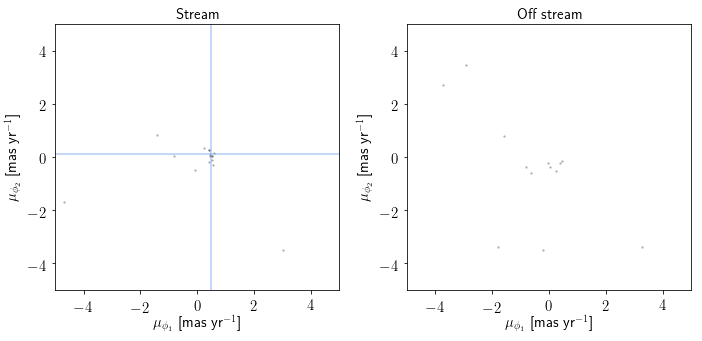

In [134]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(data['PMPHI1'][on_stream&iso_cut&ri_cut], data['PMPHI2'][on_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)

plt.axvline(pmPHI1, alpha=0.5, c='cornflowerblue')
plt.axhline(pmPHI2, alpha=0.5, c='cornflowerblue')

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(data['PMPHI1'][off_stream&iso_cut&ri_cut], data['PMPHI2'][off_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()


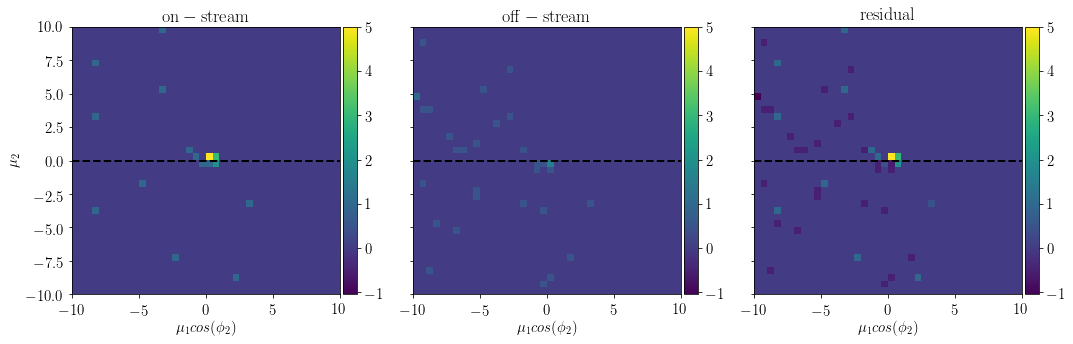

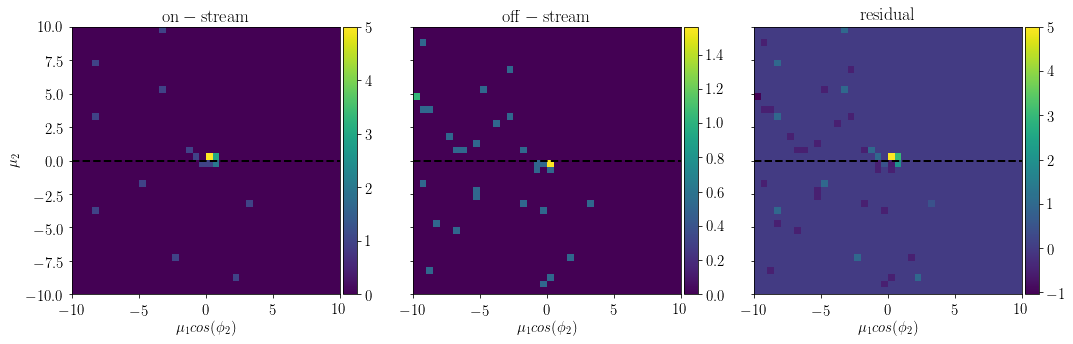

In [135]:
# uniform color scale
pm.pm_hist(stream, data[on_stream&iso_cut&ri_cut], data[off_stream&iso_cut&ri_cut], norm=pm.area_correction(data[on_stream], data[off_stream], 256), match_norm=True)
# free color scale
pm.pm_hist(stream, data[on_stream&iso_cut&ri_cut], data[off_stream&iso_cut&ri_cut], norm=pm.area_correction(data[on_stream], data[off_stream], 256), match_norm=False)

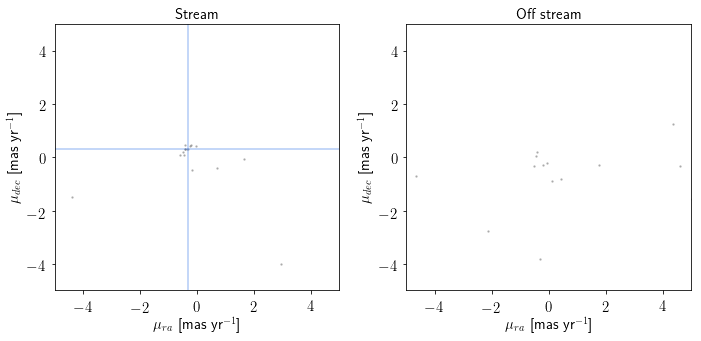

In [136]:
# pmra vs. pmdec

fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(data['PMRA'][on_stream&iso_cut&ri_cut], data['PMDEC'][on_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)

plt.axvline(pmRA, alpha=0.5, c='cornflowerblue')
plt.axhline(pmDEC, alpha=0.5, c='cornflowerblue')

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{ra}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{dec}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(data['PMRA'][off_stream&iso_cut&ri_cut], data['PMDEC'][off_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{ra}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{dec}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()


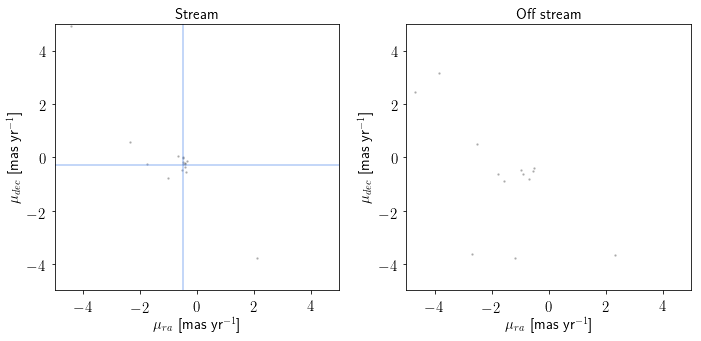

In [137]:
# pmphi1 vs. pmphi2, no reflex correction

mu = stream['modulus']
dist = pm.dist2mod(mu)
vlsr = np.array([11.1, 240., 7.3])
R = stream['matrix']
PMPHI10, PMPHI20 = pm.rotation_matrix.pmphi12(data['RA'], data['DEC'], data['PMRA0'], data['PMDEC0'], R)

fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(PMPHI10[on_stream&iso_cut&ri_cut], PMPHI20[on_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)

pmPHI10 = -0.5
pmPHI20 = -0.3
plt.axvline(pmPHI10, alpha=0.5, c='cornflowerblue')
plt.axhline(pmPHI20, alpha=0.5, c='cornflowerblue')

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{ra}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{dec}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(PMPHI10[off_stream&iso_cut&ri_cut], PMPHI20[off_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{ra}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{dec}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()


## Stream proper motion (by-eye):

In [138]:
# by-eye estimate of stream proper motion

print pmRA, pmDEC
# pmPHI1, pmPHI2 = pm.pm_transform(stream, pmRA, pmDEC)
print pmPHI1, pmPHI2
# print pmPHI10, pmPHI20

print '%.2f km/s' %(4.74 * pm.mod2dist(stream['modulus'])*1000 * pmPHI1*1e-3)

-0.3 0.3
0.5 0.1
118.78 km/s


In [139]:
# selection around stream pm in ra, dec

pm_cut = (np.abs(data['PMRA'] - pmRA) < 2*data['PMRA_ERROR']) & (np.abs(data['PMDEC'] - pmDEC) < 2*data['PMDEC_ERROR'])
pm_cut_tight = (np.abs(data['PMRA'] - pmRA) < data['PMRA_ERROR']) & (np.abs(data['PMDEC'] - pmDEC) < data['PMDEC_ERROR'])

## Visualize selected stars

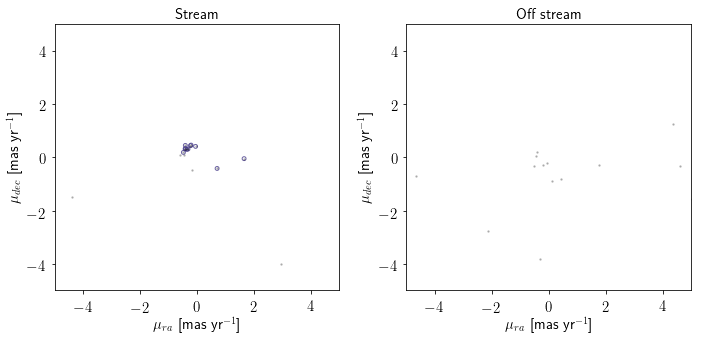

In [140]:
# pm selection highlighted

fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(data['PMRA'][on_stream&iso_cut&ri_cut], data['PMDEC'][on_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)
# plt.plot(data['PMRA'][on_stream&iso_cut&ri_cut&pm_cut], data['PMDEC'][on_stream&iso_cut&ri_cut&pm_cut], '.', c='darkslateblue', ms=3, alpha=0.8, zorder=0)
plt.scatter(data['PMRA'][on_stream&iso_cut&ri_cut&pm_cut], data['PMDEC'][on_stream&iso_cut&ri_cut&pm_cut], edgecolor='darkslateblue', s=15, facecolor='none', alpha=0.8, zorder=0)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{ra}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{dec}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(data['PMRA'][off_stream&iso_cut&ri_cut], data['PMDEC'][off_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{ra}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{dec}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.tight_layout()


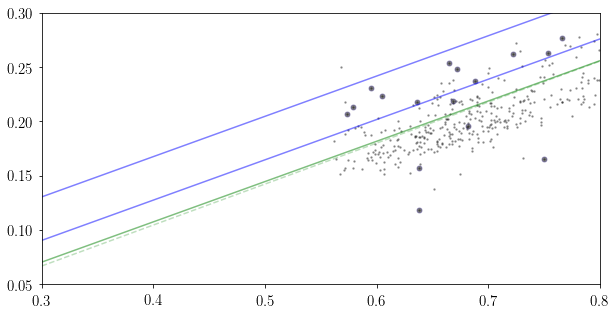

In [141]:
# pm selection highlighted

plt.figure(figsize=(10,5))

# plt.plot(data[MAGG][on_stream] - data[MAGR][on_stream], data[MAGR][on_stream] - data[MAGI][on_stream], 'k.', ms=3, alpha=0.1)
plt.plot(data[MAGG][on_stream&iso_cut] - data[MAGR][on_stream&iso_cut], data[MAGR][on_stream&iso_cut] - data[MAGI][on_stream&iso_cut], 'k.', ms=3, alpha=0.3)
# plt.plot(data[MAGG][on_stream&pm_cut] - data[MAGR][on_stream&pm_cut], data[MAGR][on_stream&pm_cut] - data[MAGI][on_stream&pm_cut], 'go', ms=5, alpha=0.5, fillstyle='none')
plt.plot(data[MAGG][on_stream&pm_cut&iso_cut] - data[MAGR][on_stream&pm_cut&iso_cut], data[MAGR][on_stream&pm_cut&iso_cut] - data[MAGI][on_stream&pm_cut&iso_cut], 'o', c='darkslateblue', ms=5, alpha=0.5, fillstyle='none')

# plt.plot(data[MAGG][off_stream&pm_cut&iso_cut] - data[MAGR][off_stream&pm_cut&iso_cut], data[MAGR][off_stream&pm_cut&iso_cut] - data[MAGI][off_stream&pm_cut&iso_cut], 'bo', ms=5, alpha=0.5, fillstyle='none')

plt.xlim(0.3,0.8)
plt.ylim(0.05,0.3)

xx = np.linspace(0.3,0.8,100)
plt.plot(xx, p[0]*xx + p[1], 'g--', alpha=0.25)
plt.plot(xx, pm.locus(xx), 'g-', alpha=0.5)
plt.plot(xx, pm.locus(xx)+0.02, 'b-', alpha=0.5)
plt.plot(xx, pm.locus(xx)+0.06, 'b-', alpha=0.5)
plt.show()

In [142]:
# number of stars on- vs. off stream

print 'Nstars on-stream: %.2f' %(np.sum(off_stream&pm_cut&iso_cut&ri_cut) * pm.area_correction(data[on_stream], data[off_stream], 256))
print 'Nstars off-stream: %.2f' %(np.sum(on_stream&pm_cut&iso_cut&ri_cut))
print 'Ratio: %.2f' %(np.sum(off_stream&pm_cut&iso_cut&ri_cut) * pm.area_correction(data[on_stream], data[off_stream], 256)/np.sum(on_stream&pm_cut&iso_cut&ri_cut))

Nstars on-stream: 1.56
Nstars off-stream: 11.00
Ratio: 0.14


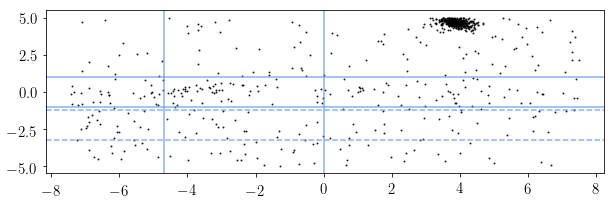

In [143]:
# spatial plot with selections
# on-stream: darkslateblue
# off-stream: green

# plt.figure(figsize=(10,3))
# plt.plot(data['PHI1'][iso_cut1&pm_cut], data['PHI2'][iso_cut1&pm_cut], 'k.', ms=2, alpha=0.8)
# plt.plot(data['PHI1'][iso_cut1&pm_cut&on_stream], data['PHI2'][iso_cut1&pm_cut&on_stream], '.', c='darkslateblue', ms=2, alpha=0.9)
# plt.plot(data['PHI1'][iso_cut1&pm_cut&off_stream], data['PHI2'][iso_cut1&pm_cut&off_stream], 'g.', ms=2, alpha=0.9)

plt.figure(figsize=(10,3))
plt.plot(data['PHI1'][iso_cut1&ri_cut&pm_cut], data['PHI2'][iso_cut1&ri_cut&pm_cut], 'k.', ms=2, alpha=0.8)
# plt.plot(data['PHI1'][iso_cut1&ri_cut&pm_cut&on_stream], data['PHI2'][iso_cut1&ri_cut&pm_cut&on_stream], '.', c='darkslateblue', ms=3, alpha=0.5)
# plt.plot(data['PHI1'][iso_cut1&ri_cut&pm_cut&off_stream], data['PHI2'][iso_cut1&ri_cut&pm_cut&off_stream], 'g.', ms=3, alpha=0.5)

plt.axhline(on_width/2., c='cornflowerblue', alpha=0.75)
plt.axhline(-on_width/2., c='cornflowerblue', alpha=0.75)
plt.axhline(-offset-off_width/2., c='cornflowerblue', alpha=0.75, ls='--')
plt.axhline(-offset+off_width/2., c='cornflowerblue', alpha=0.75, ls='--')
plt.axvline(0, c='cornflowerblue', alpha=0.75)
plt.axvline(-stream['length_deg']/2., c='cornflowerblue', alpha=0.75)

# plt.plot(data['PHI1'][pm_cut], data['PHI2'][pm_cut], 'k.', ms=2, alpha=0.8)
# plt.plot(data['PHI1'][iso_cut1&ri_cut&pm_cut&on_stream], data['PHI2'][iso_cut1&ri_cut&pm_cut&on_stream], '.', c='darkslateblue', ms=3, alpha=0.5)
# plt.plot(data['PHI1'][iso_cut1&ri_cut&pm_cut&off_stream], data['PHI2'][iso_cut1&ri_cut&pm_cut&off_stream], 'g.', ms=3, alpha=0.5)

# plt.figure(figsize=(10,3))
# plt.plot(data['PHI1'][iso_cut1&ri_cut], data['PHI2'][iso_cut1&ri_cut], 'k.', ms=2, alpha=0.8)

# plt.figure(figsize=(10,3))
# plt.plot(data['PHI1'][pm_cut&plx_cut], data['PHI2'][pm_cut&plx_cut], 'k.', ms=2, alpha=0.8)

plt.show()


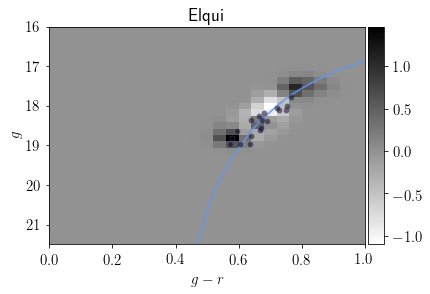

In [144]:
im = pm.plot_hess(stream, data[on_stream&iso_cut&ri_cut], data[off_stream&iso_cut&ri_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(data[MAGG][on_stream&pm_cut&iso_cut] - data[MAGR][on_stream&pm_cut&iso_cut], data[MAGG][on_stream&pm_cut&iso_cut], 'o', c='darkslateblue', ms=5, alpha=0.5, fillstyle='none')
# plt.plot(data[MAGG][on_stream&iso_cut] - data[MAGR][on_stream&iso_cut], data[MAGG][on_stream&iso_cut], '.', c='darkslateblue', ms=1, alpha=0.2, fillstyle='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

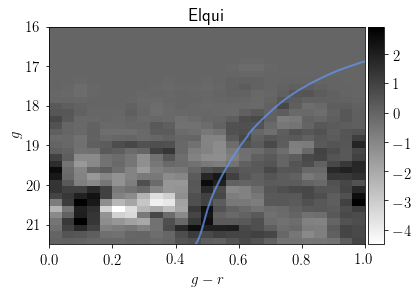

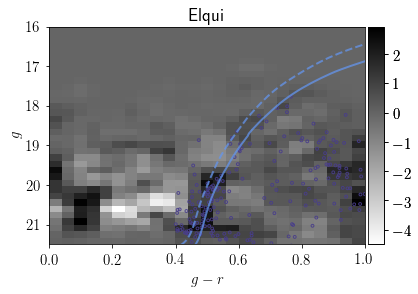

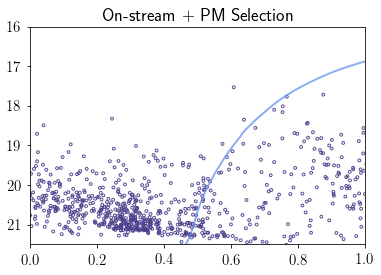

In [145]:
im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
# im = pm.plot_hess(stream, data[on_stream], data[off_stream], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
# plt.plot(data[MAGG][on_stream&pm_cut] - data[MAGR][on_stream&pm_cut], data[MAGG][on_stream&pm_cut], 'go', ms=5, alpha=0.5, fillstyle='none')
# plt.scatter(data[MAGG][on_stream&pm_cut] - data[MAGR][on_stream&pm_cut], data[MAGG][on_stream&pm_cut], s=5, alpha=0.4, edgecolor='darkslateblue', facecolor='none')
# plt.scatter(data[MAGG][on_stream&ri_cut] - data[MAGR][on_stream&ri_cut], data[MAGG][on_stream&ri_cut], s=5, alpha=0.4, edgecolor='darkslateblue', facecolor='none')
plt.scatter(data[MAGG][on_stream&ri_cut&pm_cut] - data[MAGR][on_stream&ri_cut&pm_cut], data[MAGG][on_stream&ri_cut&pm_cut], s=8, alpha=0.9, edgecolor='darkslateblue', facecolor='none')
# plt.scatter(data[MAGG][on_stream&ri_cut&pm_cut] - data[MAGR][on_stream&ri_cut&pm_cut], data[MAGG][on_stream&ri_cut&pm_cut], s=8, alpha=0.9, edgecolor='c', facecolor='none')
# plt.plot(data[MAGG][on_stream] - data[MAGR][on_stream], data[MAGG][on_stream], 'g.', ms=1, alpha=0.2, fillstyle='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

plt.figure()
# im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
# plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
# plt.scatter(data[MAGG][on_stream&pm_cut] - data[MAGR][on_stream&pm_cut], data[MAGG][on_stream&pm_cut], s=8, alpha=0.9, edgecolor='darkslateblue', facecolor='none')
plt.scatter(data[MAGG][on_stream&pm_cut_tight] - data[MAGR][on_stream&pm_cut_tight], data[MAGG][on_stream&pm_cut_tight], s=8, alpha=0.9, edgecolor='darkslateblue', facecolor='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
plt.title('On-stream + PM Selection')
pm.colorbar(im)

### Parallax Distribution of Selected Stars

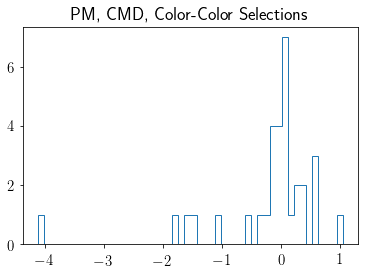

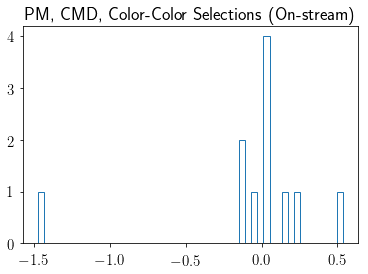

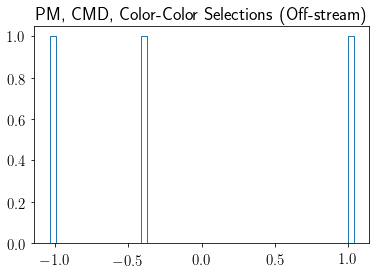

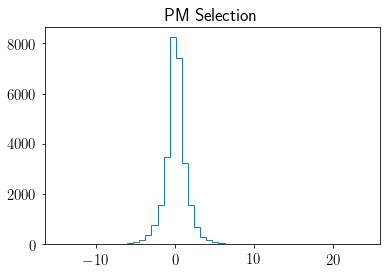

In [146]:
plt.figure()
plt.hist(data['PARALLAX'][pm_cut&iso_cut&ri_cut], bins=50, histtype='step')
plt.title('PM, CMD, Color-Color Selections')

plt.figure()
plt.hist(data['PARALLAX'][pm_cut&iso_cut&ri_cut&on_stream], bins=50, histtype='step')
plt.title('PM, CMD, Color-Color Selections (On-stream)')

plt.figure()
plt.hist(data['PARALLAX'][pm_cut&iso_cut&ri_cut&off_stream], bins=50, histtype='step')
plt.title('PM, CMD, Color-Color Selections (Off-stream)')

plt.figure()
plt.hist(data['PARALLAX'][pm_cut], bins=50, histtype='step')
plt.title('PM Selection')
# plt.xlim(-5,2)

plt.show()

## Investigating PM Clump

In [147]:
print pmra_clump, pmdec_clump
# print pmPHI1_clump, pmPHI2_clump
pm_cut_clump = (np.abs(data['PMRA'] - pmra_clump) < 2*data['PMRA_ERROR']) & (np.abs(data['PMDEC'] - pmdec_clump) < 2*data['PMDEC_ERROR'])
pm_cut_clump_tight = (np.abs(data['PMRA'] - pmra_clump) < data['PMRA_ERROR']) & (np.abs(data['PMDEC'] - pmdec_clump) < data['PMDEC_ERROR'])


-0.6 0.6


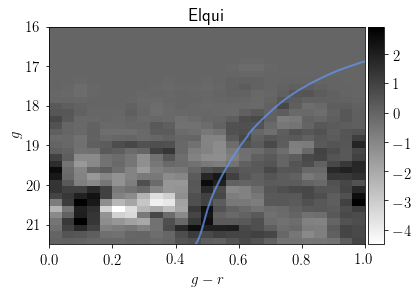

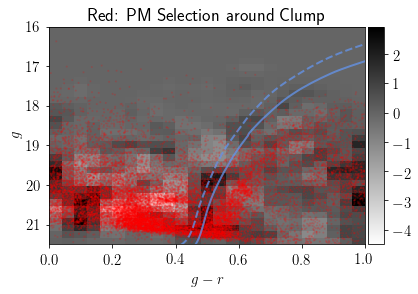

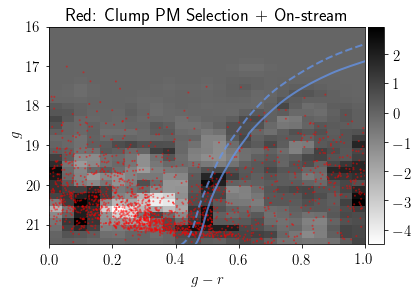

In [148]:
im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
# im = pm.plot_hess(stream, data[on_stream], data[off_stream], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.scatter(data[MAGG][pm_cut_clump] - data[MAGR][pm_cut_clump], data[MAGG][pm_cut_clump], s=1, alpha=0.2, edgecolor='r', facecolor='none')
# plt.scatter(data[MAGG][on_stream&ri_cut&pm_cut_clump] - data[MAGR][on_stream&ri_cut&pm_cut_clump], data[MAGG][on_stream&ri_cut&pm_cut_clump], s=8, alpha=0.9, edgecolor='darkslateblue', facecolor='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
plt.title('Red: PM Selection around Clump')
pm.colorbar(im)

im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.scatter(data[MAGG][on_stream&pm_cut_clump] - data[MAGR][on_stream&pm_cut_clump], data[MAGG][on_stream&pm_cut_clump], s=1, alpha=0.5, edgecolor='r', facecolor='none')
# plt.scatter(data[MAGG][on_stream&ri_cut&pm_cut_clump] - data[MAGR][on_stream&ri_cut&pm_cut_clump], data[MAGG][on_stream&ri_cut&pm_cut_clump], s=8, alpha=0.9, edgecolor='darkslateblue', facecolor='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
plt.title('Red: Clump PM Selection + On-stream')
pm.colorbar(im)


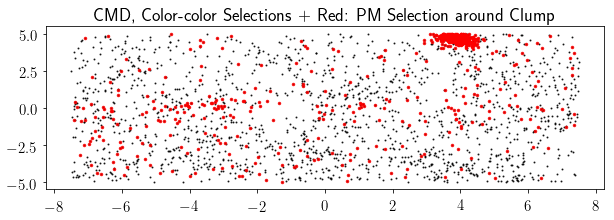

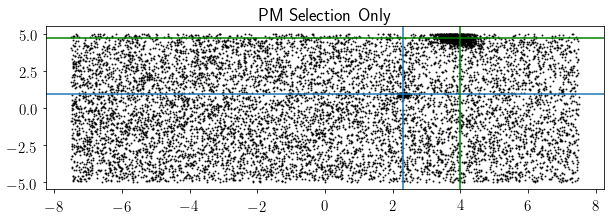

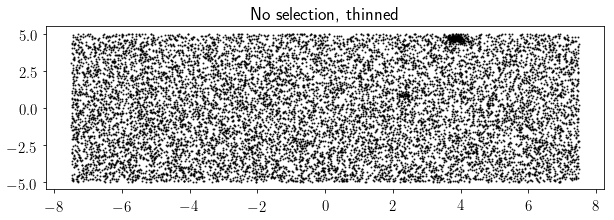

In [149]:
# spatial plot with selections

plt.figure(figsize=(10,3))
plt.plot(data['PHI1'][iso_cut1&ri_cut], data['PHI2'][iso_cut1&ri_cut], 'k.', ms=2, alpha=0.8)
plt.plot(data['PHI1'][iso_cut1&ri_cut&pm_cut_clump], data['PHI2'][iso_cut1&ri_cut&pm_cut_clump], 'r.', ms=5, alpha=0.8)
plt.title('CMD, Color-color Selections + Red: PM Selection around Clump')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(data['PHI1'][pm_cut_clump_tight], data['PHI2'][pm_cut_clump_tight], 'k.', ms=2, alpha=0.8)
# plt.plot(data['PHI1'][pm_cut_clump_tight&on_clump2], data['PHI2'][pm_cut_clump_tight&on_clump2], 'b.', ms=2, alpha=0.8)

phi1_clump2 = 2.3
phi2_clump2 = 0.9
plt.axvline(phi1_clump2)
plt.axhline(phi2_clump2)

phi1_clump3 = 4.0
phi2_clump3 = 4.7
plt.axvline(phi1_clump3, c='g')
plt.axhline(phi2_clump3, c='g')

plt.title('PM Selection Only')
plt.show()

norm = data.size / data[pm_cut_clump_tight].size
# print norm
plt.figure(figsize=(10,3))
plt.plot(data['PHI1'][::int(norm)], data['PHI2'][::int(norm)], 'k.', ms=2, alpha=0.8)
plt.title('No selection, thinned')
plt.show()



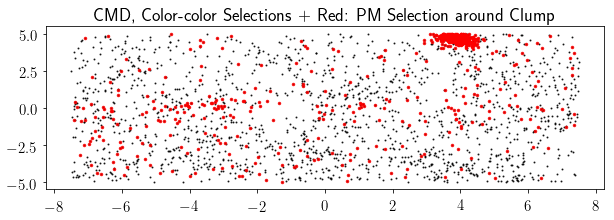

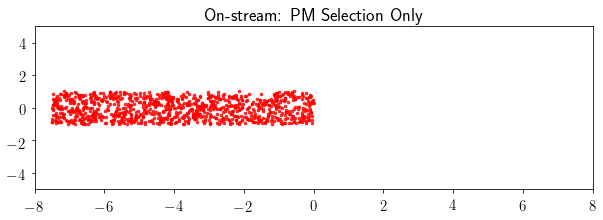

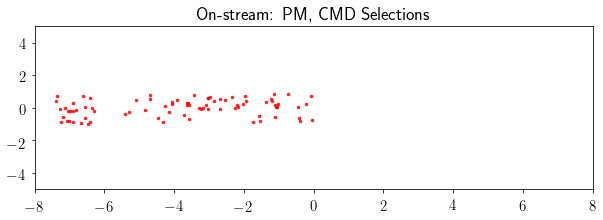

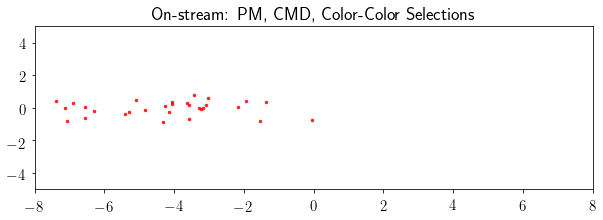

In [150]:
# spatial plot with selections
# on-stream: darkslateblue
# off-stream: green

plt.figure(figsize=(10,3))
plt.plot(data['PHI1'][iso_cut1&ri_cut], data['PHI2'][iso_cut1&ri_cut], 'k.', ms=2, alpha=0.8)
plt.plot(data['PHI1'][iso_cut1&ri_cut&pm_cut_clump], data['PHI2'][iso_cut1&ri_cut&pm_cut_clump], 'r.', ms=5, alpha=0.8)
plt.title('CMD, Color-color Selections + Red: PM Selection around Clump')

plt.figure(figsize=(10,3))
plt.plot(data['PHI1'][pm_cut_clump_tight&on_stream], data['PHI2'][pm_cut_clump_tight&on_stream], 'r.', ms=5, alpha=0.8)
plt.title('On-stream: PM Selection Only')
plt.xlim(-8,8)
plt.ylim(-5,5)

plt.figure(figsize=(10,3))
plt.plot(data['PHI1'][pm_cut_clump_tight&on_stream&iso_cut1], data['PHI2'][pm_cut_clump_tight&on_stream&iso_cut1], 'r.', ms=5, alpha=0.8)
plt.title('On-stream: PM, CMD Selections')
plt.xlim(-8,8)
plt.ylim(-5,5)

plt.figure(figsize=(10,3))
plt.plot(data['PHI1'][pm_cut_clump_tight&on_stream&iso_cut1&ri_cut], data['PHI2'][pm_cut_clump_tight&on_stream&iso_cut1&ri_cut], 'r.', ms=5, alpha=0.8)
plt.title('On-stream: PM, CMD, Color-Color Selections')
plt.xlim(-8,8)
plt.ylim(-5,5)

plt.show()



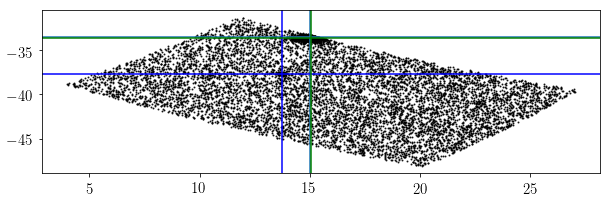

In [151]:
plt.figure(figsize=(10,3))
plt.plot(data['RA'][pm_cut_clump_tight], data['DEC'][pm_cut_clump_tight], 'k.', ms=2, alpha=0.8)
plt.axvline(15.0)
plt.axhline(-33.5)

plt.axvline(ra_NGC300, c='b')
plt.axhline(dec_NGC300, c='b')
plt.axvline(ra_sculptor, c='g')
plt.axhline(dec_sculptor, c='g')

plt.show()

## NGC 300

In [152]:
from ugali.utils.projector import angsep
sep = angsep(phi1_clump2, phi2_clump2, data['PHI1'], data['PHI2'])
on_clump2 = sep < 0.5 

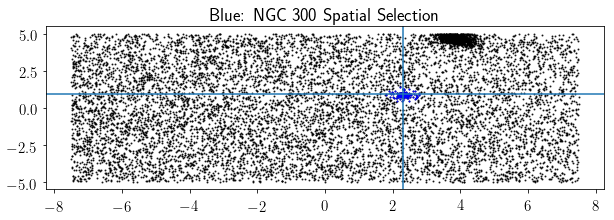

In [153]:
plt.figure(figsize=(10,3))
plt.plot(data['PHI1'][pm_cut_clump_tight], data['PHI2'][pm_cut_clump_tight], 'k.', ms=2, alpha=0.8)
plt.plot(data['PHI1'][pm_cut_clump_tight&on_clump2], data['PHI2'][pm_cut_clump_tight&on_clump2], 'b.', ms=2, alpha=0.8)

plt.axvline(phi1_clump2)
plt.axhline(phi2_clump2)

plt.title('Blue: NGC 300 Spatial Selection')
plt.show()

Text(0,0.5,'$g$')

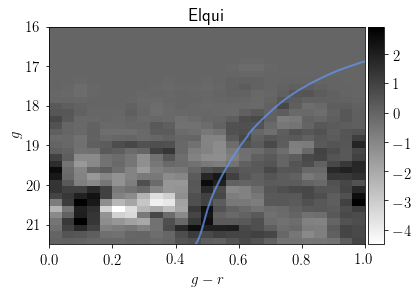

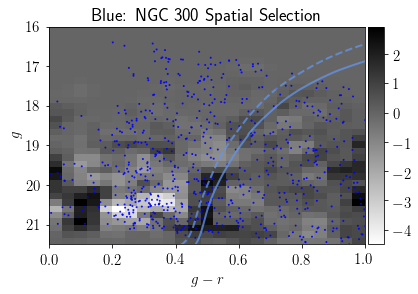

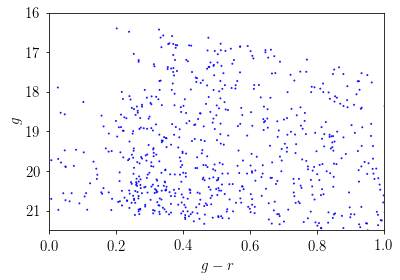

In [154]:
im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
# im = pm.plot_hess(stream, data[on_stream], data[off_stream], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.scatter(data[MAGG][on_clump2] - data[MAGR][on_clump2], data[MAGG][on_clump2], s=1, alpha=0.9, edgecolor='b', facecolor='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
plt.title('Blue: NGC 300 Spatial Selection')
pm.colorbar(im)

plt.figure()
plt.scatter(data[MAGG][on_clump2] - data[MAGR][on_clump2], data[MAGG][on_clump2], s=1, alpha=0.9, edgecolor='b', facecolor='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
plt.xlabel(r'$g-r$')
plt.ylabel(r'$g$')


## Sculptor

In [155]:
print ra_sculptor, dec_sculptor
print pmra_sculptor, pmdec_sculptor
print pmra0_sculptor, pmdec0_sculptor

15.0391667 -33.7088889
-0.23 0.45
0.09 0.02


In [156]:
from ugali.utils.projector import angsep
sep = angsep(phi1_clump3, phi2_clump3, data['PHI1'], data['PHI2'])
on_clump3 = sep < 1.0 

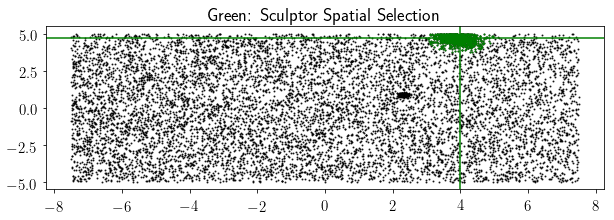

In [157]:
plt.figure(figsize=(10,3))
plt.plot(data['PHI1'][pm_cut_clump_tight], data['PHI2'][pm_cut_clump_tight], 'k.', ms=2, alpha=0.8)
plt.plot(data['PHI1'][pm_cut_clump_tight&on_clump3], data['PHI2'][pm_cut_clump_tight&on_clump3], 'g.', ms=2, alpha=0.8)

plt.axvline(phi1_clump3, c='g')
plt.axhline(phi2_clump3, c='g')

plt.title('Green: Sculptor Spatial Selection')
plt.show()

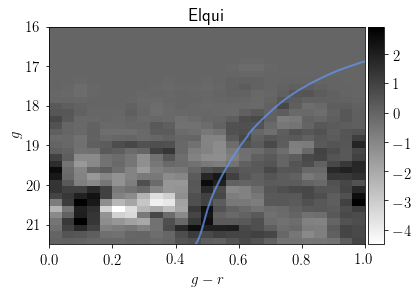

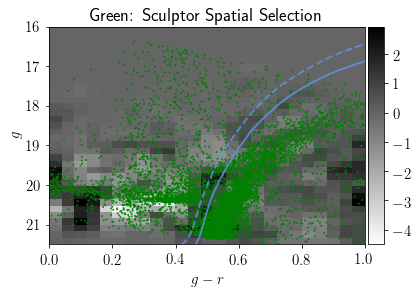

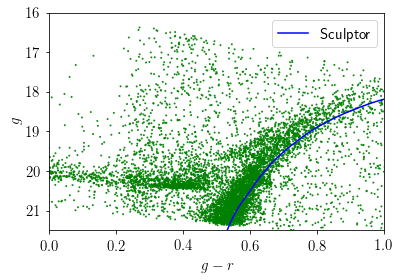

In [158]:
iso_sculptor = pm.isochrone_factory('Dotter2008', distance_modulus=19.54, age=14, metallicity=iso.feh2z(-1.42))
# Babusiaux+2005

im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
# im = pm.plot_hess(stream, data[on_stream], data[off_stream], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.xlim(0,1)
plt.ylim(21.5,16)
pm.colorbar(im)

im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.scatter(data[MAGG][on_clump3] - data[MAGR][on_clump3], data[MAGG][on_clump3], s=1, alpha=0.9, edgecolor='g', facecolor='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
plt.title('Green: Sculptor Spatial Selection')
pm.colorbar(im)

plt.figure()
plt.scatter(data[MAGG][on_clump3] - data[MAGR][on_clump3], data[MAGG][on_clump3], s=1, alpha=0.9, edgecolor='g', facecolor='none')
plt.plot(iso_sculptor.color, iso_sculptor.mag + iso_sculptor.distance_modulus, 'b-', label='Sculptor')
plt.xlim(0,1)
plt.ylim(21.5,16)
plt.xlabel(r'$g-r$')
plt.ylabel(r'$g$')
plt.legend()


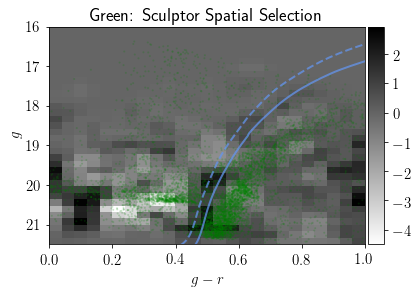

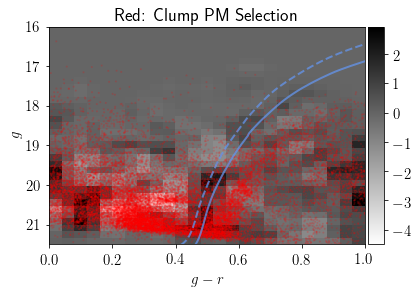

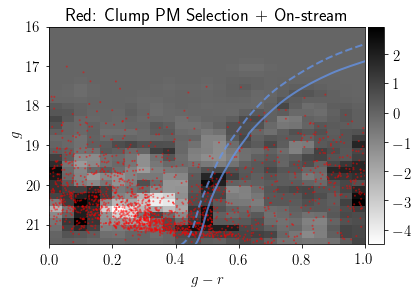

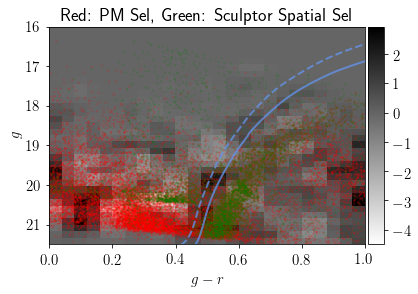

In [159]:
im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
# plt.scatter(data[MAGG][pm_cut_clump] - data[MAGR][pm_cut_clump], data[MAGG][pm_cut_clump], s=1, alpha=0.2, edgecolor='r', facecolor='none')
plt.scatter(data[MAGG][on_clump3] - data[MAGR][on_clump3], data[MAGG][on_clump3], s=1, alpha=0.2, edgecolor='g', facecolor='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
plt.title('Green: Sculptor Spatial Selection')
pm.colorbar(im)

im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.scatter(data[MAGG][pm_cut_clump] - data[MAGR][pm_cut_clump], data[MAGG][pm_cut_clump], s=1, alpha=0.2, edgecolor='r', facecolor='none')
# plt.scatter(data[MAGG][on_clump3] - data[MAGR][on_clump3], data[MAGG][on_clump3], s=1, alpha=0.2, edgecolor='g', facecolor='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
plt.title('Red: Clump PM Selection')
pm.colorbar(im)

im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.scatter(data[MAGG][on_stream&pm_cut_clump] - data[MAGR][on_stream&pm_cut_clump], data[MAGG][on_stream&pm_cut_clump], s=1, alpha=0.5, edgecolor='r', facecolor='none')
# plt.scatter(data[MAGG][on_stream&ri_cut&pm_cut_clump] - data[MAGR][on_stream&ri_cut&pm_cut_clump], data[MAGG][on_stream&ri_cut&pm_cut_clump], s=8, alpha=0.9, edgecolor='darkslateblue', facecolor='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
plt.title('Red: Clump PM Selection + On-stream')
pm.colorbar(im)

im = pm.plot_hess(stream, data[on_stream&pm_cut], data[off_stream&pm_cut], gmax=21.5)
plt.plot(iso.color, iso.mag+mu, '-', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.plot(iso2.color, iso2.mag+mu, '--', c='cornflowerblue', lw=2, alpha=0.75, zorder=1, label='%.1f Gyr\n[Fe/H]=$%.2f$' %(age, iso.z2feh(z)))
plt.scatter(data[MAGG][pm_cut_clump] - data[MAGR][pm_cut_clump], data[MAGG][pm_cut_clump], s=1, alpha=0.2, edgecolor='r', facecolor='none')
plt.scatter(data[MAGG][on_clump3] - data[MAGR][on_clump3], data[MAGG][on_clump3], s=1, alpha=0.2, edgecolor='g', facecolor='none')
plt.xlim(0,1)
plt.ylim(21.5,16)
plt.title('Red: PM Sel, Green: Sculptor Spatial Sel')
pm.colorbar(im)


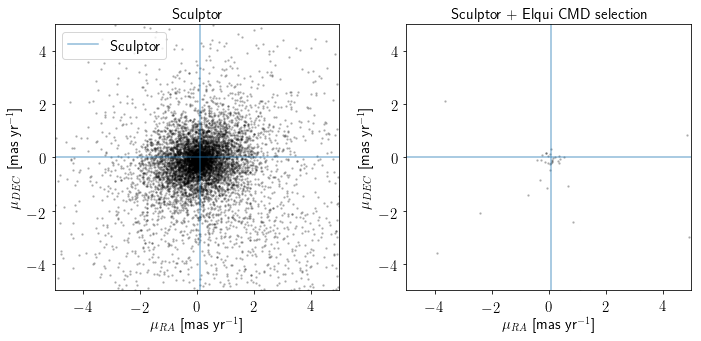

In [160]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(data['PMRA0'][on_clump3], data['PMDEC0'][on_clump3], 'k.', ms=3, alpha=0.2)
# plt.axvline(pmRA, ls='--', alpha=0.2)
# plt.axhline(pmDEC, ls='--', alpha=0.2)
plt.axvline(pmra0_sculptor, ls='-', alpha=0.5, label='Sculptor')
plt.axhline(pmdec0_sculptor, ls='-', alpha=0.5)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{RA}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{DEC}$ [mas yr$^{-1}$]')
plt.title('Sculptor', fontsize='medium')
plt.legend()

plt.sca(ax[1])
plt.plot(data['PMRA0'][on_clump3&iso_cut], data['PMDEC0'][on_clump3&iso_cut], 'k.', ms=3, alpha=0.2)
# plt.axvline(pmRA, ls='--', alpha=0.2)
# plt.axhline(pmDEC, ls='--', alpha=0.2)
plt.axvline(pmra0_sculptor, ls='-', alpha=0.5, label='Sculptor')
plt.axhline(pmdec0_sculptor, ls='-', alpha=0.5)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{RA}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{DEC}$ [mas yr$^{-1}$]')
plt.title('Sculptor + Elqui CMD selection', fontsize='medium')

plt.tight_layout()


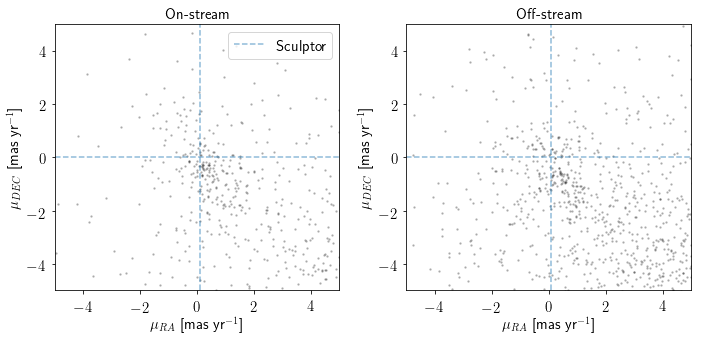

In [161]:
# Spatial & CMD cuts

fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(data['PMRA0'][on_stream&iso_cut1], data['PMDEC0'][on_stream&iso_cut1], 'k.', ms=3, alpha=0.2)
# plt.axvline(pmRA, ls='--', alpha=0.2)
# plt.axhline(pmDEC, ls='--', alpha=0.2)
plt.axvline(pmra0_sculptor, ls='--', alpha=0.5, label='Sculptor')
plt.axhline(pmdec0_sculptor, ls='--', alpha=0.5)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{RA}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{DEC}$ [mas yr$^{-1}$]')
plt.title('On-stream', fontsize='medium')
plt.legend()

plt.sca(ax[1])
plt.plot(data['PMRA0'][off_stream&iso_cut1], data['PMDEC0'][off_stream&iso_cut1], 'k.', ms=3, alpha=0.2)
# plt.axvline(pmRA, ls='--', alpha=0.2)
# plt.axhline(pmDEC, ls='--', alpha=0.2)
plt.axvline(pmra0_sculptor, ls='--', alpha=0.5, label='Sculptor')
plt.axhline(pmdec0_sculptor, ls='--', alpha=0.5)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{RA}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{DEC}$ [mas yr$^{-1}$]')
plt.title('Off-stream', fontsize='medium')

plt.tight_layout()


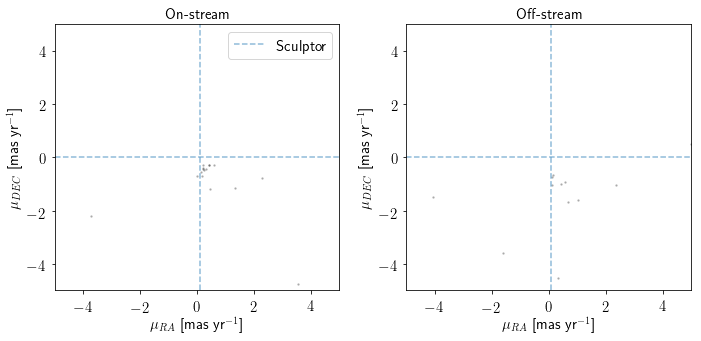

In [162]:
# Spatial, CMD, color-color cuts

fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(data['PMRA0'][on_stream&iso_cut&ri_cut], data['PMDEC0'][on_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)
# plt.axvline(pmRA, ls='--', alpha=0.2)
# plt.axhline(pmDEC, ls='--', alpha=0.2)
plt.axvline(pmra0_sculptor, ls='--', alpha=0.5, label='Sculptor')
plt.axhline(pmdec0_sculptor, ls='--', alpha=0.5)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{RA}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{DEC}$ [mas yr$^{-1}$]')
plt.title('On-stream', fontsize='medium')
plt.legend()

plt.sca(ax[1])
plt.plot(data['PMRA0'][off_stream&iso_cut&ri_cut], data['PMDEC0'][off_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)
# plt.axvline(pmRA, ls='--', alpha=0.2)
# plt.axhline(pmDEC, ls='--', alpha=0.2)
plt.axvline(pmra0_sculptor, ls='--', alpha=0.5, label='Sculptor')
plt.axhline(pmdec0_sculptor, ls='--', alpha=0.5)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{RA}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{DEC}$ [mas yr$^{-1}$]')
plt.title('Off-stream', fontsize='medium')

plt.tight_layout()


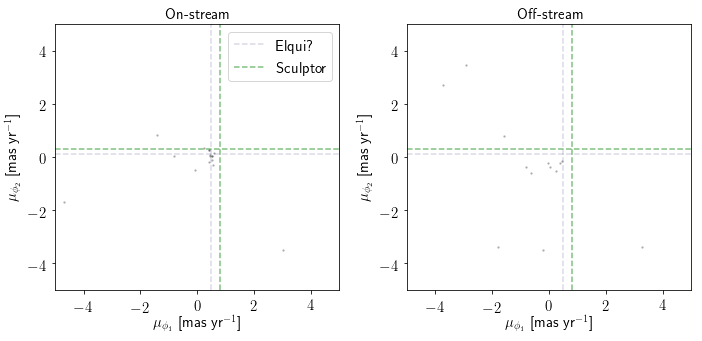

In [163]:
# Streem coords
# Spatial, CMD, color-color cuts

fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.plot(data['PMPHI1'][on_stream&iso_cut&ri_cut], data['PMPHI2'][on_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)

plt.axvline(pmPHI1, ls='--', alpha=0.2, c='darkslateblue', label='Elqui?')
plt.axhline(pmPHI2, ls='--', alpha=0.2, c='darkslateblue')
plt.axvline(pmphi1_sculptor, ls='--', alpha=0.5, c='g', label='Sculptor')
plt.axhline(pmphi2_sculptor, ls='--', alpha=0.5, c='g')

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('On-stream', fontsize='medium')
plt.legend()

plt.sca(ax[1])
plt.plot(data['PMPHI1'][off_stream&iso_cut&ri_cut], data['PMPHI2'][off_stream&iso_cut&ri_cut], 'k.', ms=3, alpha=0.2)

plt.axvline(pmPHI1, ls='--', alpha=0.2, c='darkslateblue', label='Elqui?')
plt.axhline(pmPHI2, ls='--', alpha=0.2, c='darkslateblue')
plt.axvline(pmphi1_sculptor, ls='--', alpha=0.5, c='g', label='Sculptor')
plt.axhline(pmphi2_sculptor, ls='--', alpha=0.5, c='g')

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Off-stream', fontsize='medium')

plt.tight_layout()
